In [1]:
import os
import json

from pathlib import Path
from collections import defaultdict, Counter
from itertools import chain, starmap

import numpy as np
import pandas as pd
from scipy.stats import weibull_min
import matplotlib.pyplot as plt

### Load Weather Report data

Covers January 12 to 21 2021, with readings every 10 minutes

- "Time" column contains timestamps in format yyyy-mm-dd hh:mm:ss
- Time series features for training are Relative Humidity ("RelHum"), Wind and Gust Speed ("WindSpd", "GustSpd")
- Categorical features for the model include the (integer) station id, and (float) latitude and longitude

In [2]:
wr = pd.read_csv("../data/sce.csv", parse_dates=["Time", "Date"])
wr.head()

,Status,Mnet_Id,Elevation,Name,Elev_Dem,Longitude,State,Restricted,Qc_Flagged,Latitude,Timezone,Id,Period_Of_Record.Start,Period_Of_Record.End,Time,RelHum,WindSpd,GustSpd,Date,Station
0,ACTIVE,231,6388,SCE Marion Ridge,6400.9,-116.73432,CA,False,False,33.76594,America/Los_Angeles,70844,2018-06-11 20:11:00+00:00,2021-06-09 17:50:00+00:00,2021-01-12 00:00:00,30.89,2.87,6.43,2021-01-12,SE001
1,ACTIVE,231,6388,SCE Marion Ridge,6400.9,-116.73432,CA,False,False,33.76594,America/Los_Angeles,70844,2018-06-11 20:11:00+00:00,2021-06-09 17:50:00+00:00,2021-01-12 00:10:00,30.83,3.27,8.26,2021-01-12,SE001
2,ACTIVE,231,6388,SCE Marion Ridge,6400.9,-116.73432,CA,False,False,33.76594,America/Los_Angeles,70844,2018-06-11 20:11:00+00:00,2021-06-09 17:50:00+00:00,2021-01-12 00:20:00,31.16,2.16,6.06,2021-01-12,SE001
3,ACTIVE,231,6388,SCE Marion Ridge,6400.9,-116.73432,CA,False,False,33.76594,America/Los_Angeles,70844,2018-06-11 20:11:00+00:00,2021-06-09 17:50:00+00:00,2021-01-12 00:30:00,32.43,1.29,4.38,2021-01-12,SE001
4,ACTIVE,231,6388,SCE Marion Ridge,6400.9,-116.73432,CA,False,False,33.76594,America/Los_Angeles,70844,2018-06-11 20:11:00+00:00,2021-06-09 17:50:00+00:00,2021-01-12 00:40:00,32.18,1.32,3.58,2021-01-12,SE001


In [3]:
wr.WindSpd.describe()

count    971461.000000
mean          6.033779
std           6.057898
min           0.000000
25%           1.940000
50%           3.970000
75%           8.010000
max          70.640000
Name: WindSpd, dtype: float64

<AxesSubplot:>

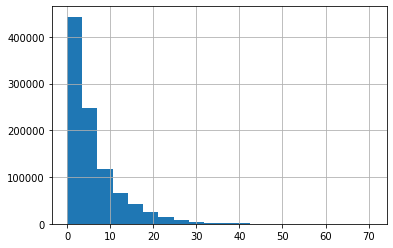

In [4]:
wr.WindSpd.hist(bins=20)

In [7]:
c, loc, scale = weibull_min.fit(wr.WindSpd.dropna())

array([1.27075357e-01, 1.35963723e-01, 1.38722072e-01, ...,
       4.56019552e-06, 4.55189239e-06, 4.54360432e-06])

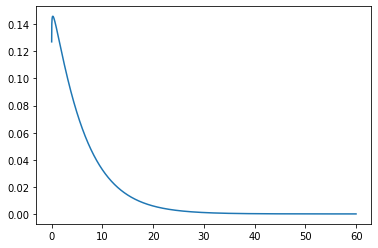

In [9]:
x = np.arange(0,60,.01)
y = weibull_min.pdf((x - loc)/scale, c)/scale
plt.plot(x,y)

In [10]:
wr_dt_columns = ["Date", "Time"]
wr_ts_columns = ["RelHum", "WindSpd", "GustSpd"]
wr_cat_columns = ["Station"]
wr_cat_real_columns = ["Latitude", "Longitude"]

We identify the extreme values in humidity and wind by percentile, and filter those stations that recorded these values for later inspection.  Note that the thresholds used by SCE are 31 and 46 mph for wind and gust, respectively, which roughly corresponds to the 99th percentile

In [11]:
wind_gust_perc = wr[["WindSpd", "GustSpd"]].describe(percentiles=np.arange(0,1,.01))[-10:]
wind_gust_perc

,WindSpd,GustSpd
91%,14.91,26.96
92%,15.66,28.12
93%,16.51,29.37
94%,17.45,30.83
95%,18.61,32.44
96%,20.01,34.34
97%,21.81,36.74
98%,24.29,40.04
99%,28.12,45.23
max,70.64,98.90


In [12]:
hum_perc = wr["RelHum"].describe(percentiles=np.arange(0,1,.01))[4:15]
hum_perc

0%      0.88
1%      9.00
2%      9.97
3%     10.67
4%     11.22
5%     11.67
6%     12.05
7%     12.40
8%     12.73
9%     13.02
10%    13.31
Name: RelHum, dtype: float64

In [13]:
outliers = wr[(wr.WindSpd > wind_gust_perc.WindSpd["99%"]) & (wr.GustSpd > wind_gust_perc.GustSpd["99%"]) & (wr.RelHum < hum_perc["10%"])]

In [14]:
outliers.Id.unique()

array([ 71312,  72882,  88896,  89911,  89912,  92121, 108441, 125752,
       139780, 141651, 141652, 142942, 150331, 151178, 152233, 152320,
       152639, 152640, 152657, 152687, 156554, 156555])

### Visualizations by Station

Plots of humidity and wind speed

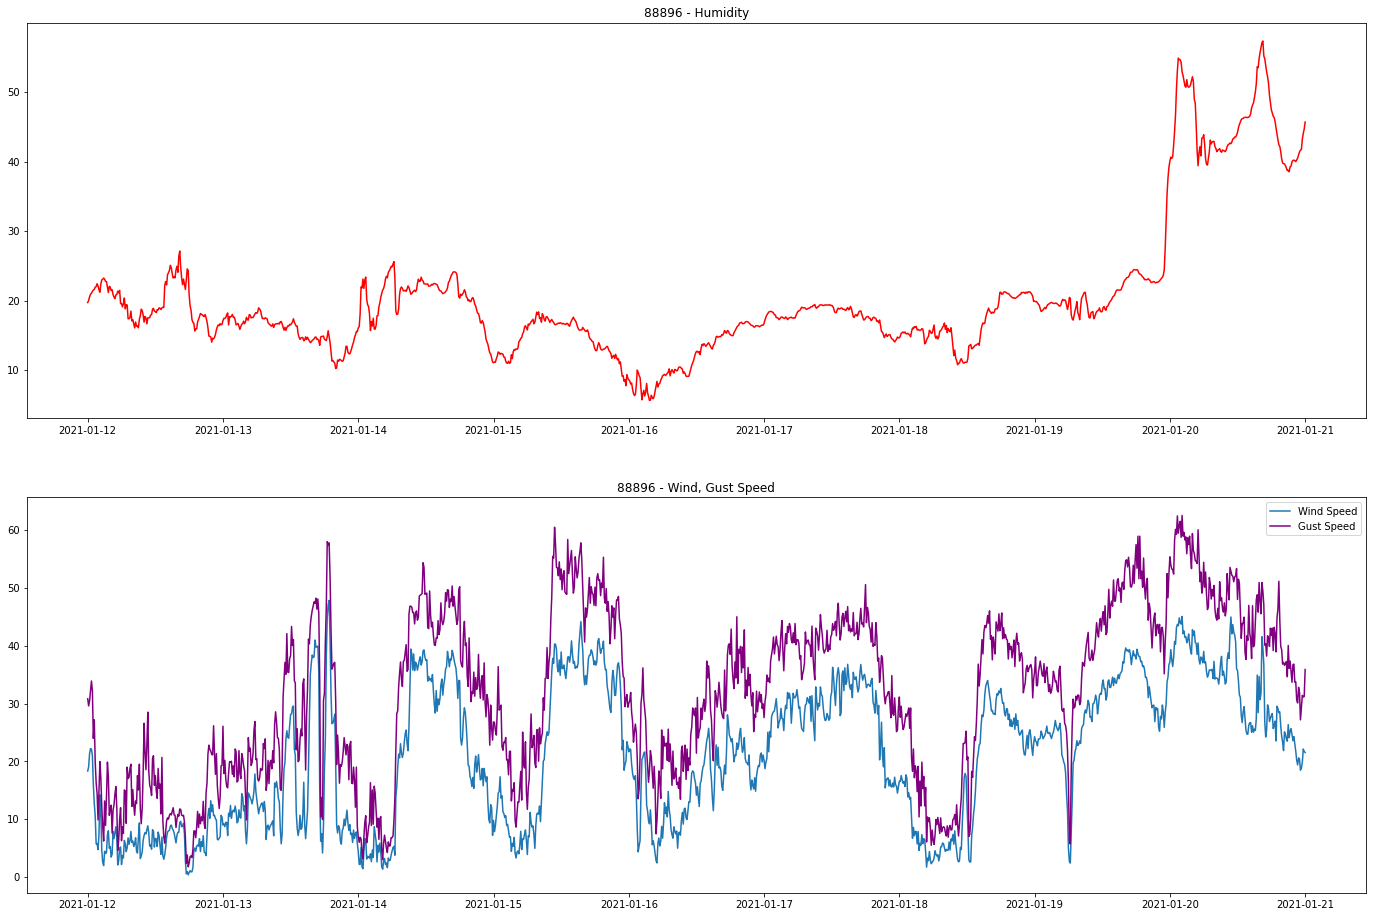

In [15]:
station_id = 88896
wrs = wr[(wr.Id==station_id)].copy().set_index("Time")
fig, ax = plt.subplots(2, 1,figsize=(24,16))

ax[0].plot(wrs["RelHum"], color="red", label="Relative Humidity")
ax[0].set_title("{} - Humidity".format(station_id, "RelHum"))    

ax[1].plot(wrs["WindSpd"], label="Wind Speed")
ax[1].plot(wrs["GustSpd"], color="purple", label="Gust Speed")
ax[1].set_title("{} - Wind, Gust Speed".format(station_id, "WindSpd"))
ax[1].legend()

## GlutonTS

In this section we prepare the data for training with GluonTS, and train their DeepAR model

In [16]:
from gluonts.mx.trainer import Trainer
from gluonts.model.predictor import Predictor
from gluonts.evaluation import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator

/usr/local/anaconda3/envs/gluon-ts/lib/python3.8/site-packages/gluonts/json.py:45: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [17]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deepvar import DeepVAREstimator

For preprocessing, we do the following:
- Make a copy of the dataset
- Remove duplicates based on the values in the Id, time series, and categorical features column
- Set the index as the "Time" column (helpful/required by gluonts)
- Cut-off the data after January 20th, this time period was chosen based on analysis of PSPS reports from SCE
- Filter out stations with missing values; there should be 1152 readings for the 8 day period

In [18]:
wr_gts = wr.copy()
wr_gts.drop_duplicates(subset = ["Id"] + wr_ts_columns + wr_dt_columns, inplace=True)
wr_gts.set_index(["Time"], inplace=True)
wr_gts = wr_gts.loc[:"2021-01-20 00:00:00"]

In [19]:
# Filter out weather stations with < 8 days worth of 10-minute data
wr_gts_id_counts = wr_gts.groupby("Id").count().RelHum
wr_gts_ids = wr_gts_id_counts[wr_gts_id_counts >= 1152].index
wr_gts = wr_gts[wr_gts.Id.isin(wr_gts_ids)]

In [20]:
print("Number of Weather Stations:  {}".format(wr_gts.Id.unique().shape))
print("Number of records:  {}".format(wr_gts.index.shape))

Number of Weather Stations:  (261,)
Number of records:  (300901,)


In [21]:
wr_gts.head()

,Status,Mnet_Id,Elevation,Name,Elev_Dem,Longitude,State,Restricted,Qc_Flagged,Latitude,Timezone,Id,Period_Of_Record.Start,Period_Of_Record.End,RelHum,WindSpd,GustSpd,Date,Station
Time,,,,,,,,,,,,,,,,,,,
2021-01-12 00:00:00,ACTIVE,231,6388,SCE Marion Ridge,6400.9,-116.73432,CA,False,False,33.76594,America/Los_Angeles,70844,2018-06-11 20:11:00+00:00,2021-06-09 17:50:00+00:00,30.89,2.87,6.43,2021-01-12,SE001
2021-01-12 00:10:00,ACTIVE,231,6388,SCE Marion Ridge,6400.9,-116.73432,CA,False,False,33.76594,America/Los_Angeles,70844,2018-06-11 20:11:00+00:00,2021-06-09 17:50:00+00:00,30.83,3.27,8.26,2021-01-12,SE001
2021-01-12 00:20:00,ACTIVE,231,6388,SCE Marion Ridge,6400.9,-116.73432,CA,False,False,33.76594,America/Los_Angeles,70844,2018-06-11 20:11:00+00:00,2021-06-09 17:50:00+00:00,31.16,2.16,6.06,2021-01-12,SE001
2021-01-12 00:30:00,ACTIVE,231,6388,SCE Marion Ridge,6400.9,-116.73432,CA,False,False,33.76594,America/Los_Angeles,70844,2018-06-11 20:11:00+00:00,2021-06-09 17:50:00+00:00,32.43,1.29,4.38,2021-01-12,SE001
2021-01-12 00:40:00,ACTIVE,231,6388,SCE Marion Ridge,6400.9,-116.73432,CA,False,False,33.76594,America/Los_Angeles,70844,2018-06-11 20:11:00+00:00,2021-06-09 17:50:00+00:00,32.18,1.32,3.58,2021-01-12,SE001


In [22]:
wr_gts.Id.unique()

array([ 70844,  70845,  70847,  70848,  70852,  70855,  70856,  70857,
        70858,  70859,  70861,  70862,  70864,  70867,  70868,  71065,
        71066,  71067,  71071,  71082,  71083,  71307,  71308,  71309,
        71310,  71311,  71312,  71313,  71456,  71464,  71477,  71717,
        71720,  71732,  71819,  71820,  71824,  71825,  71909,  71910,
        71946,  71953,  71954,  71958,  71959,  71975,  71982,  72006,
        72007,  72020,  72021,  72048,  72070,  72074,  72075,  72076,
        72151,  72152,  72153,  72163,  72165,  72190,  72206,  72472,
        72486,  72496,  72499,  72500,  72501,  72503,  72776,  72778,
        72828,  72879,  72881,  72883,  72884,  72885,  72886,  72887,
        72888,  72889,  72960,  75111,  75296,  75299,  75320,  88896,
        88902,  89436,  89555,  89581,  89586,  89587,  89630,  89631,
        89652,  89653,  89667,  89669,  89670,  89677,  89680,  89681,
        89701,  89702,  89712,  89734,  89735,  89765,  89766,  89886,
      

In [23]:
# Same outlier computation as above, now for filtered data
train_outliers = wr_gts[(wr_gts.WindSpd > wind_gust_perc.WindSpd["99%"]) & (wr_gts.GustSpd > wind_gust_perc.GustSpd["99%"]) & (wr_gts.RelHum < hum_perc["10%"])]
train_outliers.Id.unique()

array([71312, 88896, 89911, 89912])

In [24]:
# We take all data up to the 19th for training, and test with the data up to the 20th
training_time_cutoff = "2021-01-19 00:00:00"
testing_time_cutoff = "2021-01-20 00:00:00"

In [25]:
# We group data by station Id, separate out the three features of humidity, wind, and gust, and format them into dictionaries as required by GluonTS
all_single_training_datasets = []
for (station_id, df) in wr_gts.groupby("Id"):
    tss = df[wr_ts_columns].transpose().iterrows()
    for (c, ts) in tss:
        all_single_training_datasets.append({
            "item_id": "Training:  {} - {}".format(station_id, c),
            "start": ts.index[0],
            "target": ts.loc[:training_time_cutoff],
            "feat_static_cat": [station_id],
            "feat_static_real": [df[wr_cat_real_columns[0]].unique()[0], df[wr_cat_real_columns[1]].unique()[0]] #lat, long
        })

In [26]:
all_single_training_datasets[0]

{'item_id': 'Training:  70844 - RelHum',
 'start': Timestamp('2021-01-12 00:00:00'),
 'target': Time
 2021-01-12 00:00:00    30.89
 2021-01-12 00:10:00    30.83
 2021-01-12 00:20:00    31.16
 2021-01-12 00:30:00    32.43
 2021-01-12 00:40:00    32.18
                        ...  
 2021-01-18 23:20:00    21.12
 2021-01-18 23:30:00    21.28
 2021-01-18 23:40:00    21.44
 2021-01-18 23:50:00    21.83
 2021-01-19 00:00:00    22.28
 Name: RelHum, Length: 1009, dtype: float64,
 'feat_static_cat': [70844],
 'feat_static_real': [33.76594, -116.73432]}

In [27]:
all_single_training_data = ListDataset(
    all_single_training_datasets,
    freq = "10min",
)

In [28]:
next(iter(all_single_training_data))

{'item_id': 'Training:  70844 - RelHum',
 'start': Timestamp('2021-01-12 00:00:00', freq='10T'),
 'target': array([30.89, 30.83, 31.16, ..., 21.44, 21.83, 22.28], dtype=float32),
 'feat_static_cat': array([70844], dtype=int32),
 'feat_static_real': array([  33.76594, -116.73432], dtype=float32),
 'source': SourceContext(source='list_data', row=0)}

In [38]:
from gluonts.model.tpp.distribution.weibull import WeibullOutput

In [75]:
estimator = DeepAREstimator(
    freq="10min", 
    prediction_length=6*24, # 24-hour prediction
    trainer=Trainer(epochs=50, batch_size=64, patience=5), 
    num_layers=5,
    num_cells=60,
    use_feat_static_cat = True, cardinality = [wr.Id.unique().shape[0]], 
    use_feat_static_real = True,
)

### Train a new model...

In [76]:
predictor = estimator.train(training_data=all_single_training_data)

100%|██████████| 50/50 [00:52<00:00,  1.05s/it, epoch=50/50, avg_epoch_loss=1.77]


Early stopping based on learning rate scheduler callback (min_lr was reached).


In [22]:
# prefix = "../models/"
# model_name = "model-sce-15L-100E-1P"
# try:
#     os.mkdir(prefix + model_name)
# finally:
#     predictor.serialize(Path(prefix + model_name))

In [93]:
# predictor = Predictor.deserialize(Path("../models/model-sce-20L-100E"))
# predictor.prediction_length

144

### Visualize Predictions

In [45]:
train_outliers.Id.unique()

array([71312, 88896, 89911, 89912])

In [77]:
test_station_id = 71312
wr_test = wr_gts[(wr_gts.Id==test_station_id)]

single_test_datasets = []

for (c, ts) in wr_test[wr_ts_columns].transpose().iterrows():
    single_test_datasets.append({
        "item_id": "Testing:  {} - {}".format(test_station_id, c),
        "start": ts.index[0],
        "target": ts.loc[:testing_time_cutoff],
        "feat_static_cat": [test_station_id],
        "feat_static_real": [wr_test[wr_cat_real_columns[0]].unique()[0], wr_test[wr_cat_real_columns[1]].unique()[0]]
    })

In [78]:
single_test_data = ListDataset(
    single_test_datasets,
    freq = "10min",
)

In [79]:
sforecast_it, sts_it = make_evaluation_predictions(
    dataset=single_test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=1000,  # number of sample paths we want for evaluation
)

In [80]:
sforecasts = list(sforecast_it)
stss = list(sts_it)

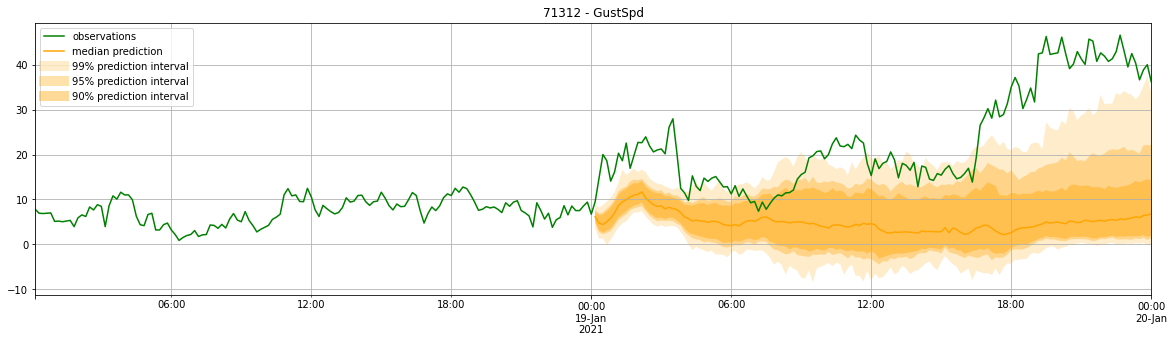

In [81]:
plot_length = 2*6*24
prediction_intervals = [90,95,99]
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

fig, ax = plt.subplots(1, 1, figsize=(20, 5))

i = 2
stss[i][-plot_length:].plot(ax=ax, color="green")  # plot the time series
sforecasts[i].plot(prediction_intervals=prediction_intervals, color='orange')

# plt.ylim(0,40)
plt.title("{} - {}".format(test_station_id, wr_ts_columns[i]))
plt.grid(which="both")
plt.legend(legend, loc="upper left")
plt.show()

### Gluon-ts Metrics

In [82]:
all_single_test_datasets = []
for (station_id, df) in wr_gts.groupby("Id"):
    tss = df[wr_ts_columns].transpose().iterrows()
    for (c, ts) in tss:
        all_single_test_datasets.append({
            "item_id": "Testing:  {} - {}".format(station_id, c),
            "start": ts.index[0],
            "target": ts.loc[:testing_time_cutoff],
            "feat_static_cat": [station_id],
            "feat_static_real": [df[wr_cat_real_columns[0]].unique()[0], df[wr_cat_real_columns[1]].unique()[0]] #lat, long
        })

In [83]:
all_single_test_data = ListDataset(
    all_single_test_datasets,
    freq = "10min",
)

In [84]:
forecast_all_it, ts_all_it = make_evaluation_predictions(
    dataset=all_single_test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=500,  # number of sample paths we want for evaluation
)

In [ ]:
evaluator = Evaluator(quantiles=[.75, .90, .99])
agg_metrics, item_metrics = evaluator(ts_all_it, forecast_all_it, num_series=len(all_single_test_data))

Running evaluation:   0%|          | 0/783 [00:00<?, ?it/s]

In [ ]:
# 5L 60N 50E 64B
agg_metrics

In [66]:
# 10L 60N
agg_metrics

{'MSE': 557.0327400896161,
 'abs_error': 1573452.5485610962,
 'abs_target_sum': 2324367.9580230713,
 'abs_target_mean': 20.61645604456557,
 'seasonal_error': 5.254247747738797,
 'MASE': 2.6960359326374985,
 'MAPE': 1.254153175837623,
 'sMAPE': 0.6262561568328181,
 'MSIS': 24.5385053661464,
 'QuantileLoss[0.75]': 1347863.6521756947,
 'Coverage[0.75]': 0.7357948784477304,
 'QuantileLoss[0.9]': 839511.6593012331,
 'Coverage[0.9]': 0.8188911844745314,
 'QuantileLoss[0.99]': 185639.88018341787,
 'Coverage[0.99]': 0.936245103667261,
 'RMSE': 23.601541053279046,
 'NRMSE': 1.14479137453405,
 'ND': 0.6769378071703217,
 'wQuantileLoss[0.75]': 0.5798839411476331,
 'wQuantileLoss[0.9]': 0.361178468496553,
 'wQuantileLoss[0.99]': 0.07986682123311874,
 'mean_absolute_QuantileLoss': 791005.0638867818,
 'mean_wQuantileLoss': 0.34030974362576827,
 'MAE_Coverage': 0.04968961113682576,
 'OWA': nan}

In [55]:
# 5L 60N
agg_metrics

{'MSE': 250.36258044966314,
 'abs_error': 1197290.867980957,
 'abs_target_sum': 2324367.9580230713,
 'abs_target_mean': 20.61645604456557,
 'seasonal_error': 5.254247747738797,
 'MASE': 2.2130912691969202,
 'MAPE': 0.9285756473923791,
 'sMAPE': 0.5926792516535176,
 'MSIS': 37.2831747644631,
 'QuantileLoss[0.75]': 1174570.2879185304,
 'Coverage[0.75]': 0.6267742211329983,
 'QuantileLoss[0.9]': 977719.0833617807,
 'Coverage[0.9]': 0.687179901934907,
 'QuantileLoss[0.99]': 550140.2966751873,
 'Coverage[0.99]': 0.8002702629476683,
 'RMSE': 15.822849947138574,
 'NRMSE': 0.7674864153632954,
 'ND': 0.5151038431106582,
 'wQuantileLoss[0.75]': 0.5053288933295783,
 'wQuantileLoss[0.9]': 0.42063868587887154,
 'wQuantileLoss[0.99]': 0.23668382399449972,
 'mean_absolute_QuantileLoss': 900809.8893184994,
 'mean_wQuantileLoss': 0.3875504677343165,
 'MAE_Coverage': 0.1752585379948088,
 'OWA': nan}

In [36]:
# 5L 40N
agg_metrics

{'MSE': 239.5998161269741,
 'abs_error': 1150112.1615600586,
 'abs_target_sum': 2324367.9580230713,
 'abs_target_mean': 20.61645604456557,
 'seasonal_error': 5.254247747738797,
 'MASE': 2.1493368002976267,
 'MAPE': 0.9762127081861738,
 'sMAPE': 0.5851119116417557,
 'MSIS': 29.56051136751671,
 'QuantileLoss[0.75]': 1183156.597097002,
 'Coverage[0.75]': 0.6357589800907755,
 'QuantileLoss[0.9]': 969632.5584891022,
 'Coverage[0.9]': 0.712130698734228,
 'QuantileLoss[0.99]': 477695.74095998285,
 'Coverage[0.99]': 0.8323026897004286,
 'RMSE': 15.479012117282359,
 'NRMSE': 0.7508085814468862,
 'ND': 0.49480640859386804,
 'wQuantileLoss[0.75]': 0.5090229337455262,
 'wQuantileLoss[0.9]': 0.41715966490684075,
 'wQuantileLoss[0.99]': 0.20551640256058,
 'mean_absolute_QuantileLoss': 876828.2988486956,
 'mean_wQuantileLoss': 0.3772330004043156,
 'MAE_Coverage': 0.15326921049152264,
 'OWA': nan}

In [37]:
item_metrics.sort_values("Coverage[0.99]")

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.75],Coverage[0.75],QuantileLoss[0.9],Coverage[0.9],QuantileLoss[0.99],Coverage[0.99]
221,Testing: 72879 - GustSpd,479.539605,2855.359131,4028.219727,27.973748,2.359954,8.402234,0.712552,0.974612,179.462244,3692.529844,0.173611,3707.592233,0.194444,2132.816867,0.256944
80,Testing: 71312 - GustSpd,314.721680,1933.324951,3371.069824,23.410207,15.977224,0.840313,0.486424,0.674059,25.789458,2652.376211,0.208333,2920.540249,0.229167,2668.108255,0.270833
39,Testing: 70867 - RelHum,2447.387804,6293.758789,10824.279297,75.168606,7.332855,5.960387,0.543044,0.708397,159.814940,8397.327181,0.270833,8936.384024,0.298611,6906.062220,0.312500
162,Testing: 72075 - RelHum,1879.239583,5454.650391,10767.150391,74.771878,5.366474,7.058548,0.446004,0.594660,139.267422,7110.491817,0.236111,7084.071332,0.236111,3385.819938,0.312500
777,Testing: 157441 - RelHum,1788.988281,5124.002930,8808.549805,61.170485,4.183542,8.505557,0.524920,0.678527,233.747432,6896.068037,0.263889,7394.685428,0.298611,6051.730051,0.319444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,Testing: 90707 - RelHum,1308.838542,4571.343750,4449.889648,30.902011,9.958832,3.187667,1.309124,0.697378,63.085737,2753.712654,1.000000,1304.000013,1.000000,176.081095,1.000000
529,Testing: 90706 - WindSpd,33.415168,707.097778,999.059998,6.937917,4.490417,1.093529,1.081351,0.937326,4.847197,745.890358,0.409722,516.191675,0.569444,26.857290,1.000000
69,Testing: 71309 - RelHum,94.175551,1206.091064,2867.689941,19.914513,5.150035,1.626325,0.463541,0.355858,17.009212,835.204372,1.000000,432.616406,1.000000,66.307301,1.000000
244,Testing: 72889 - WindSpd,19.428684,532.165405,1216.130005,8.445347,1.961379,1.884181,0.620970,0.436478,11.591618,429.763077,0.895833,297.432658,1.000000,58.023334,1.000000
